# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pandas as pd
from scipy import ndimage, misc

import os
import glob

import warnings
warnings.filterwarnings('ignore')

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import fftpack

matplotlib.rc("savefig",dpi=100)

## Image analysis imports

In [2]:
# skimage imports
from skimage import exposure
from skimage.color import rgb2gray
from skimage import color
from skimage.util import crop
from skimage.transform import rotate
# catch annoying precision warnings for certain 
# skimage operations
import warnings
warnings.catch_warnings()

catch_warnings()

In [3]:
from image_helper import (add_scalebar, constantMeanContrast,
                                radial_profile_fft,d_from_fft)

In [4]:
micron_per_pixel = {'4x':1000/696, '10x':1000/1750,
                       '20x':500/1740, '50x':230/2016}
image_width_pixels = 2048
image_width_microns = {}
for k,v in micron_per_pixel.items():
    image_width_microns[k]=v*image_width_pixels
print(image_width_microns)

image_area_microns={}
for k,v in image_width_microns.items():
    image_area_microns[k]=v**2 * 1536/2048

print(image_area_microns)

{'4x': 2942.5287356321837, '10x': 1170.2857142857142, '20x': 588.5057471264367, '50x': 233.65079365079364}
{'4x': 6493856.520015854, '10x': 1027176.4897959183, '20x': 259754.26080063413, '50x': 40944.520030234315}


# Pattern Quality of 163 C TPBi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


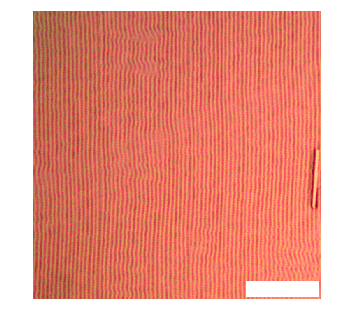

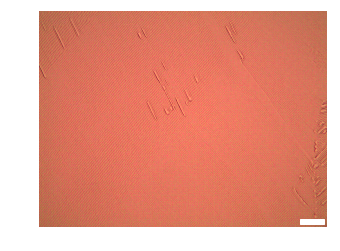

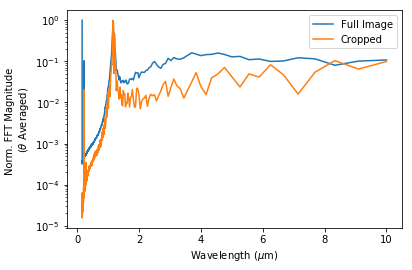

In [5]:
# Exemplary 163 C TPBi image
image_file = 'T=162.5C_Mag=50x_Polarized=0_-000007.png'
# Load file
img = misc.imread(os.path.join('example images',image_file))

# Rotate
rot_img = rotate(img,angle=-30)
# Crop - image[y1:y2,x1:x2]
# width = 600
# y1 = 150
# x1 = 250
width = 700
y1 = 200
x1 = 175
crop_img = rot_img[y1:y1+width,x1:x1+width]
# Improve contrast
crop_img = constantMeanContrast(crop_img,3)

fig,ax = plt.subplots(figsize=(4,crop_img.shape[0]/crop_img.shape[1]*4))
ax.imshow(crop_img)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('tight')
ax.axis('off')
add_scalebar(ax,length=20,unit='um',mag='50x',
             show_label=False,height=35)
plt.show()

fig,ax = plt.subplots(figsize=(4,img.shape[0]/img.shape[1]*4))
ax.imshow(img)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('tight')
ax.axis('off')
add_scalebar(ax,length=20,unit='um',mag='50x',
             show_label=False,height=35)
plt.show()

before_crop=d_from_fft(img,order=15,d_upper=2)
after_crop=d_from_fft(crop_img,order=15,d_upper=2)
plt.semilogy(1/before_crop['k'],before_crop['radial']/np.amax(before_crop['radial']),label='Full Image')
plt.semilogy(1/after_crop['k'],after_crop['radial']/np.amax(after_crop['radial']),label='Cropped')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Norm. FFT Magnitude \n' +  r'($\theta$ Averaged)')
plt.legend()

# Si vs. Si/Au pattern quality 
Measure pattern quality using FFT magnitude from multiple crop regions per image. Crop regions the same dimension as the reference image are used to ensure the FFT magnitude is comparable. Multiple crop regions are used (non-overlapping) to increase sample size for building histograms.
Note that a limited selection of images are included in this repository. The full image set used for the analysis in the paper can be obtained by contacting the corresponding author of the article at https://doi.org/10.1038/s41563-019-0379-3.

In [7]:
# Au/TPBi analysis with cropping 165C
# Images to analyze
au_dir = os.path.join('example images','Au')
image_files = glob.glob(os.path.join(au_dir,'*.tif'))
# Loop through and calculate FFTs
au_165C_fft=[]
x1_list=[0,0,600,600,1200,1200]
y1_list=[0,600,0,600,0,600]
width = 600
for i,image_file in enumerate(image_files):
    # Load file
    img = misc.imread(image_file)
    for ci,y1 in enumerate(y1_list):
        x1=x1_list[ci]
        crop_img = img[y1:y1+width,x1:x1+width]
        au_165C_fft.append(d_from_fft(crop_img,order=15,d_upper=2))
# average the portion of the fft spectrum between 2 and 4 microns
# and plot a histogram
au_165C_average_fft_2_to_4_um=[]
for i,d in enumerate(au_165C_fft):
    wavelength=1/d['k']
    norm_range_idx = np.logical_and(wavelength<2.5,wavelength>.8)
    norm_fft = d['radial']/np.amax(d['radial'][norm_range_idx])
    avg_range_idx = np.logical_and(wavelength<4,wavelength>2)
    au_165C_average_fft_2_to_4_um.append(np.mean(norm_fft[avg_range_idx]))

In [8]:
# Si/TPBi analysis with cropping 160C
# Images to analyze
si_dir = os.path.join('example images','Si')
image_files = glob.glob(os.path.join(si_dir,'*.tif'))
# Loop through and calculate FFTs
Si_165C=[]
x1_list=[0,0,600,600,1200,1200]
y1_list=[0,600,0,600,0,600]
width = 600
for i,image_file in enumerate(image_files):
    # Load file
    img = misc.imread(image_file)
    for ci,y1 in enumerate(y1_list):
        x1=x1_list[ci]
        crop_img = img[y1:y1+width,x1:x1+width]
        Si_165C.append(d_from_fft(crop_img,order=15,d_upper=2))
# average the portion of the fft spectrum between 2 and 4 microns
# and plot a histogram
Si_165C_average_fft_2_to_4_um=[]
for i,d in enumerate(Si_165C):
    wavelength=1/d['k']
    norm_range_idx = np.logical_and(wavelength<2.5,wavelength>.8)
    norm_fft = d['radial']/np.amax(d['radial'][norm_range_idx])
    avg_range_idx = np.logical_and(wavelength<4,wavelength>2)
    Si_165C_average_fft_2_to_4_um.append(np.mean(norm_fft[avg_range_idx]))

In [14]:
# Get average quality from the reference image\
wavelength=1/after_crop['k']
norm_range_idx = np.logical_and(wavelength<2.5,wavelength>.8)
norm_fft = after_crop['radial']/np.amax(after_crop['radial'][norm_range_idx])
range_idx = np.logical_and(wavelength<4,wavelength>2)
ref_avg = np.mean(norm_fft[range_idx])

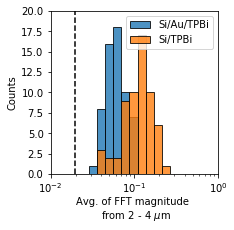

In [15]:
# Plot histograms
fig,ax=plt.subplots(figsize=(3,3))
nbins=35
upper=2
lower=1e-3
plt.hist(au_165C_average_fft_2_to_4_um,edgecolor='k',label='Si/Au/TPBi',
         bins=np.logspace(np.log10(lower),np.log10(upper), nbins),alpha=0.8)
binwidth=0.005
plt.hist(Si_165C_average_fft_2_to_4_um,edgecolor='k',label='Si/TPBi',
         bins=np.logspace(np.log10(lower),np.log10(upper), nbins),alpha=0.8)
plt.plot([ref_avg,ref_avg],[0,60],'--k')
plt.xlabel('Avg. of FFT magnitude \n from 2 - 4 $\mu$m')
plt.ylabel('Counts')
plt.xscale('log')
plt.xlim(1e-2,1)
plt.ylim(0,60)
ax.axis([1e-2,1,0,20])
plt.legend()